In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from kneed import KneeLocator
import seaborn as sns # Seaborn (version : 0.11.1)
plt.style.use('seaborn')

In [4]:
# Load the dataset
data = pd.read_csv('Mall_Customers.csv')
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [5]:
# Display the first few rows of the dataset
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
# Select the desired features (Age, Annual Income, and Spending Score)
X = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'CustomerID']]

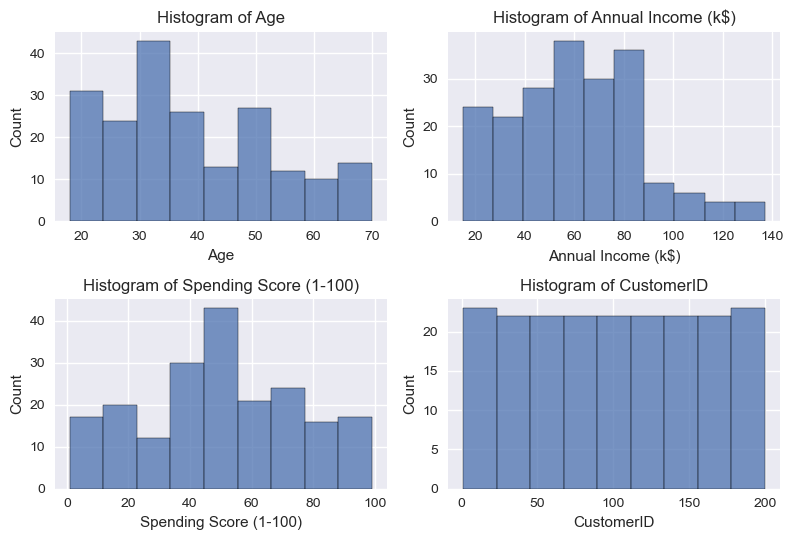

In [7]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2)

# Flatten the subplots array into a 1D array
axs = axs.ravel()

# Iterate over the columns of the X DataFrame and their corresponding subplot axes
for i, col in enumerate(X.columns):
    # Plot a histogram of the current column on the corresponding subplot axis
    sns.histplot(X[col], ax=axs[i])
    
    # Set the title of the subplot to indicate the column name
    axs[i].set_title('Histogram of ' + col)


plt.tight_layout()
plt.show()

In [8]:
for i,col in enumerate(data.columns):
    print(f'Column number {1+i} is {col}')
    
data.dtypes

Column number 1 is CustomerID
Column number 2 is Gender
Column number 3 is Age
Column number 4 is Annual Income (k$)
Column number 5 is Spending Score (1-100)


CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [10]:
data.isnull()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
195,False,False,False,False,False
196,False,False,False,False,False
197,False,False,False,False,False
198,False,False,False,False,False


In [11]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [12]:
data = data.drop('CustomerID', axis=1)
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [13]:
data = data.rename(columns={'Annual Income (k$)':'Annual_Income','Spending Score (1-100)':'Spending_Score'})
data.head()

,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [14]:
corr = data.corr()
corr

,Age,Annual_Income,Spending_Score
Age,1.000000,-0.012398,-0.327227
Annual_Income,-0.012398,1.000000,0.009903
Spending_Score,-0.327227,0.009903,1.000000


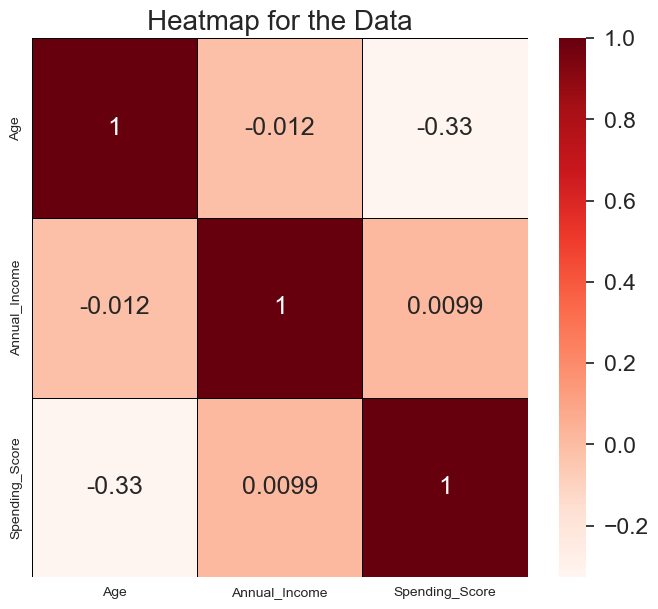

In [15]:
fig, ax = plt.subplots(figsize=(8,7))
sns.set(font_scale=1.5)
ax = sns.heatmap(corr, cmap = 'Reds', annot = True, linewidths=0.5, linecolor='black')
plt.title('Heatmap for the Data', fontsize = 20)
plt.show()

Text(0, 0.5, 'Count')

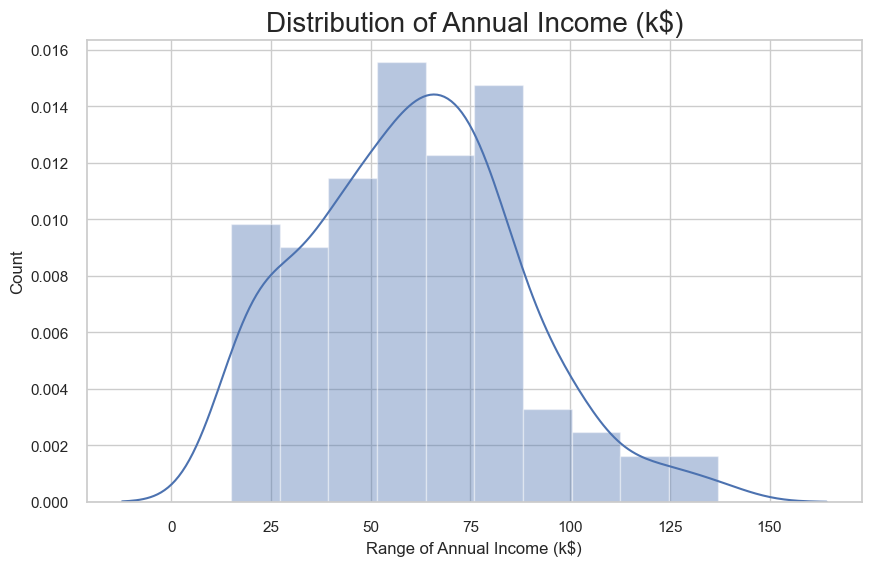

In [16]:
#Distribution of Annnual Income
plt.figure(figsize=(10, 6))
sns.set(style = 'whitegrid')
sns.distplot(data['Annual_Income'])
plt.title('Distribution of Annual Income (k$)', fontsize = 20)
plt.xlabel('Range of Annual Income (k$)')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

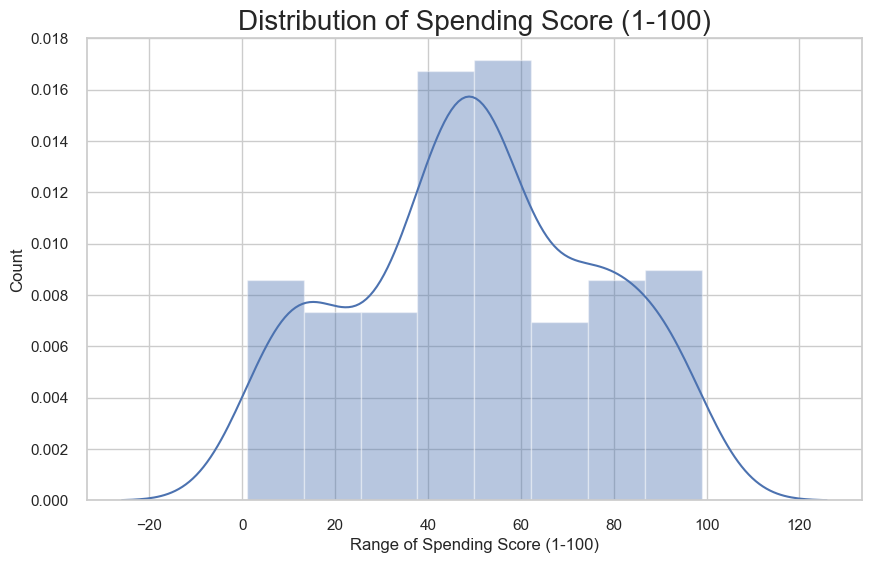

In [17]:
#Distribution of spending score
plt.figure(figsize=(10, 6))
sns.set(style = 'whitegrid')
sns.distplot(data['Spending_Score'])
plt.title('Distribution of Spending Score (1-100)', fontsize = 20)
plt.xlabel('Range of Spending Score (1-100)')
plt.ylabel('Count')

In [18]:
data['Gender'].head()

0      Male
1      Male
2    Female
3    Female
4    Female
Name: Gender, dtype: object

In [19]:
data['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

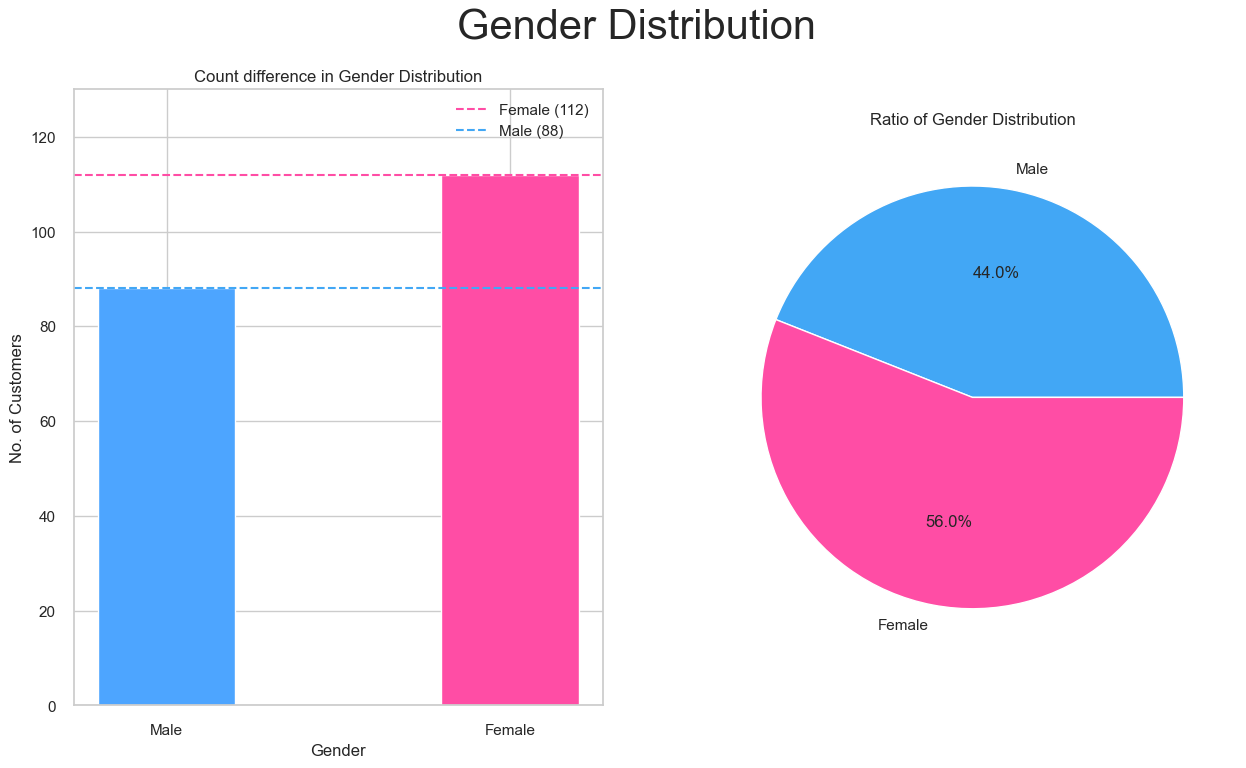

In [20]:
labels=data['Gender'].unique()
values=data['Gender'].value_counts(ascending=True)


fig, (ax0,ax1) = plt.subplots(ncols=2,figsize=(15,8))
bar = ax0.bar(x=labels, height=values, width=0.4, align='center', color=['#4da5ff','#ff4da5'])
ax0.set(title='Count difference in Gender Distribution',xlabel='Gender', ylabel='No. of Customers')
ax0.set_ylim(0,130)
ax0.axhline(y=data['Gender'].value_counts()[0], color='#ff4da5', linestyle='--', label=f'Female ({data.Gender.value_counts()[0]})')
ax0.axhline(y=data['Gender'].value_counts()[1], color='#42a7f5', linestyle='--', label=f'Male ({data.Gender.value_counts()[1]})')
ax0.legend()


ax1.pie(values,labels=labels,colors=['#42a7f5','#ff4da5'],autopct='%1.1f%%')
ax1.set(title='Ratio of Gender Distribution')
fig.suptitle('Gender Distribution', fontsize=30);
plt.show()

In [21]:
data[data['Gender']=='Male']['Age'].describe()

count    88.000000
mean     39.806818
std      15.514812
min      18.000000
25%      27.750000
50%      37.000000
75%      50.500000
max      70.000000
Name: Age, dtype: float64

In [22]:
data[data['Gender']=='Female']['Age'].describe()

count    112.000000
mean      38.098214
std       12.644095
min       18.000000
25%       29.000000
50%       35.000000
75%       47.500000
max       68.000000
Name: Age, dtype: float64

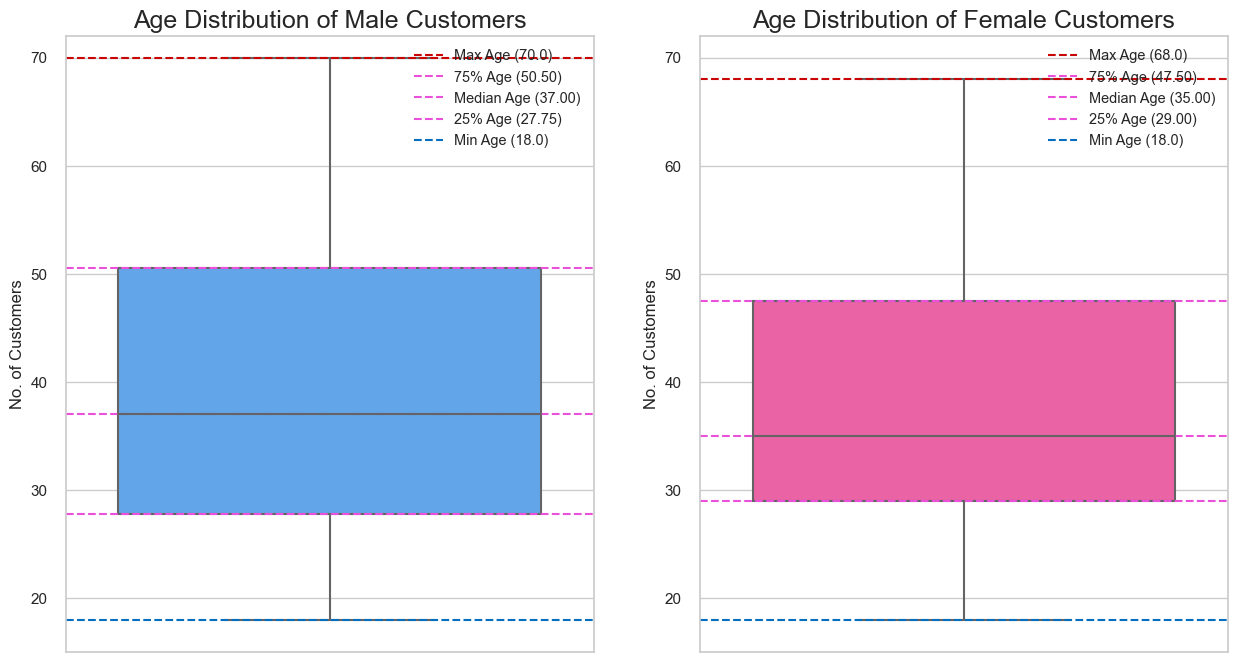

In [23]:
data_male = data[data['Gender']=='Male']['Age'].describe()
data_female = data[data['Gender']=='Female']['Age'].describe()

fig, (ax0,ax1) = plt.subplots(ncols=2,figsize=(15,8))
sns.set(font_scale=1.5)
sns.boxplot(y=data[data['Gender']=='Male']['Age'], color="#4da5ff", ax=ax0)
ax0.axhline(y=data['Age'].max(), linestyle='--',color='#c90404', label=f'Max Age ({data_male[7]})')
ax0.axhline(y=data_male[6], linestyle='--',color='#eb50db', label=f'75% Age ({data_male[6]:.2f})')
ax0.axhline(y=data_male[5], linestyle='--',color='#eb50db', label=f'Median Age ({data_male[5]:.2f})')
ax0.axhline(y=data_male[4], linestyle='--',color='#eb50db', label=f'25% Age ({data_male[4]:.2f})')
ax0.axhline(y=data_male[3], linestyle='--',color='#046ebf', label=f'Min Age ({data_male[3]})')
ax0.legend(fontsize='xx-small', loc='upper right')
ax0.set(ylabel='No. of Customers', title='Age Distribution of Male Customers')
ax0.set_ylim(15,72)

ax1 = sns.boxplot(y=data[data['Gender']=='Female']['Age'], color="#ff4da5", ax=ax1)
ax1.axhline(y=data_female[7], linestyle='--',color='#c90404', label=f'Max Age ({data_female[7]})')
ax1.axhline(y=data_female[6], linestyle='--',color='#eb50db', label=f'75% Age ({data_female[6]:.2f})')
ax1.axhline(y=data_female[5], linestyle='--',color='#eb50db', label=f'Median Age ({data_female[5]:.2f})')
ax1.axhline(y=data_female[4], linestyle='--',color='#eb50db', label=f'25% Age ({data_female[4]:.2f})')
ax1.axhline(y=data_female[3], linestyle='--',color='#046ebf', label=f'Min Age ({data_female[3]})')
ax1.legend(fontsize='xx-small', loc='upper right')
ax1.set(ylabel='No. of Customers', title='Age Distribution of Female Customers')
ax1.set_ylim(15,72)

plt.show()

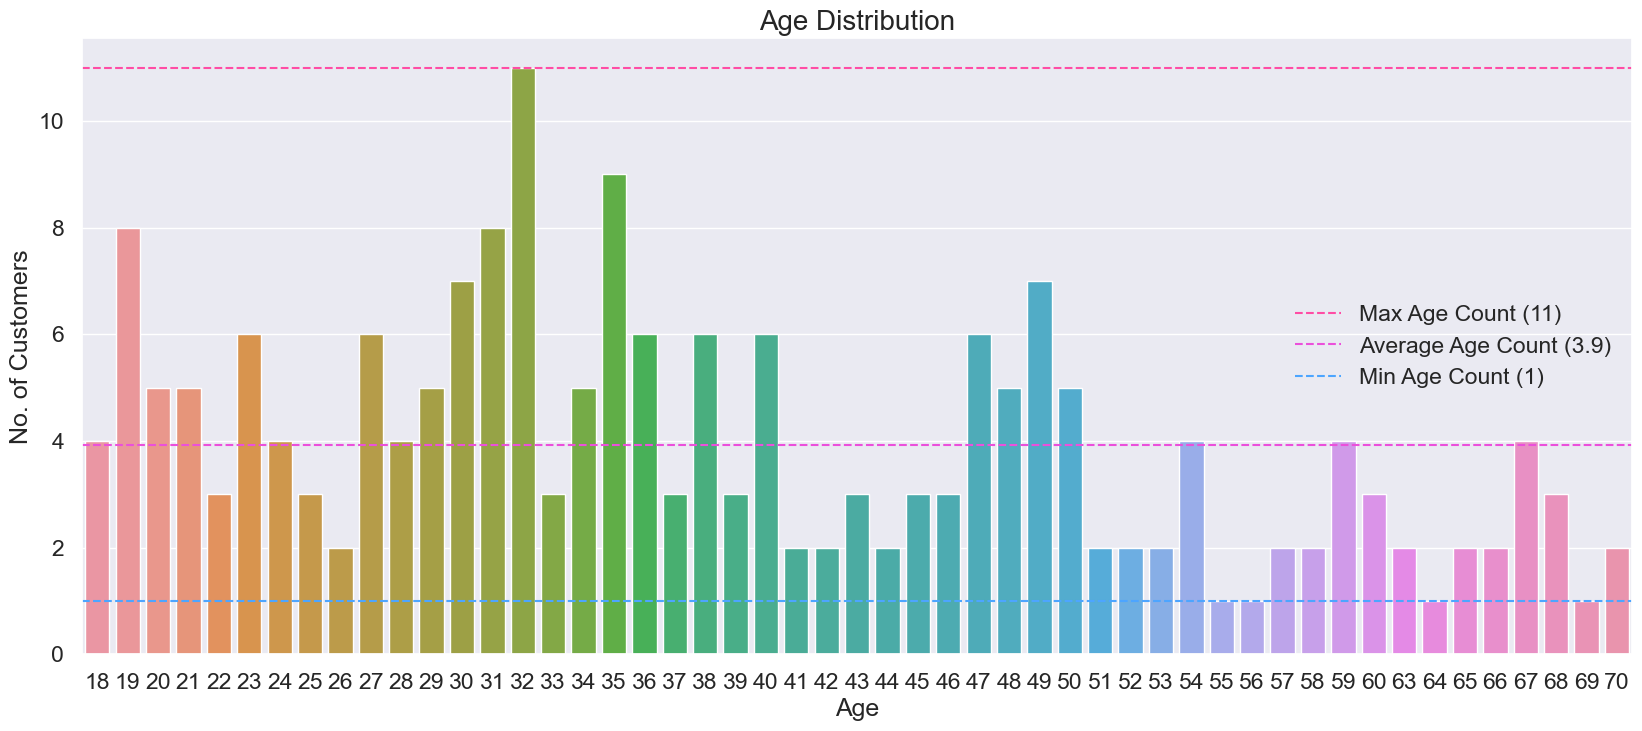

In [24]:
fig, ax = plt.subplots(figsize=(20,8))
sns.set(font_scale=1.5)
ax = sns.countplot(x=data['Age']) #palette='spring'
ax.axhline(y=data['Age'].value_counts().max(), linestyle='--',color='#ff4da5', label=f'Max Age Count ({data.Age.value_counts().max()})')
ax.axhline(y=data['Age'].value_counts().mean(), linestyle='--',color='#eb50db', label=f'Average Age Count ({data.Age.value_counts().mean():.1f})')
ax.axhline(y=data['Age'].value_counts().min(), linestyle='--',color='#4da5ff', label=f'Min Age Count ({data.Age.value_counts().min()})')
ax.legend(loc ='right')
ax.set_ylabel('No. of Customers')

plt.title('Age Distribution', fontsize = 20)
plt.show()

In [25]:
data['Annual_Income'].value_counts().head()

54    12
78    12
48     6
71     6
63     6
Name: Annual_Income, dtype: int64

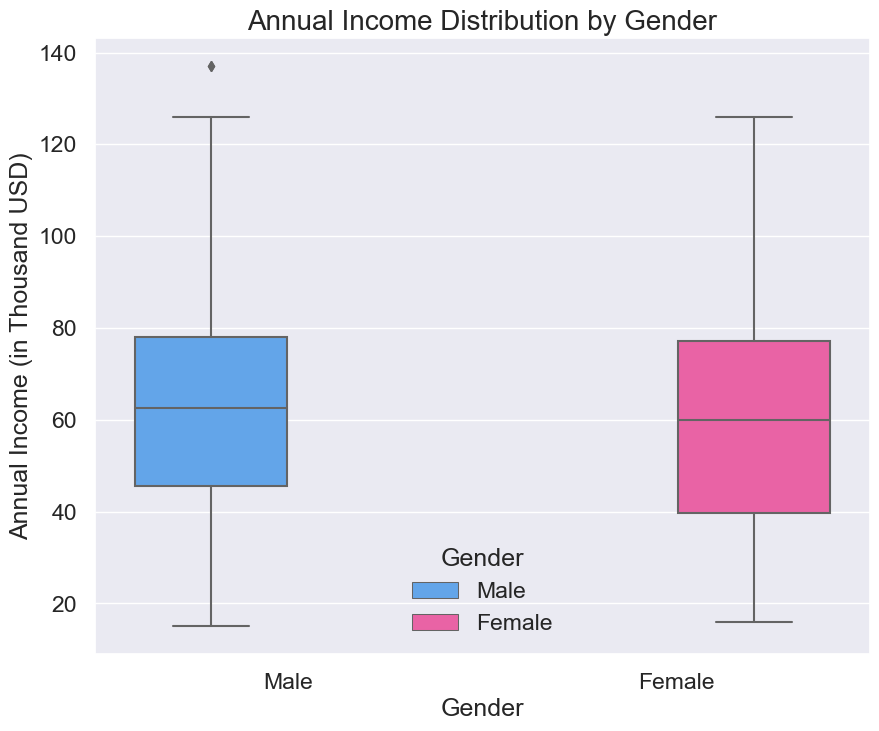

In [26]:
# Define custom colors for gender
custom_palette = {'Male': '#4da5ff', 'Female': '#ff4da5'}

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.set(font_scale=1.5)
ax = sns.boxplot(x=data['Gender'], y=data["Annual_Income"], hue=data['Gender'], palette=custom_palette)

ax.set_ylabel('Annual Income (in Thousand USD)')

plt.title('Annual Income Distribution by Gender', fontsize=20)

plt.show()

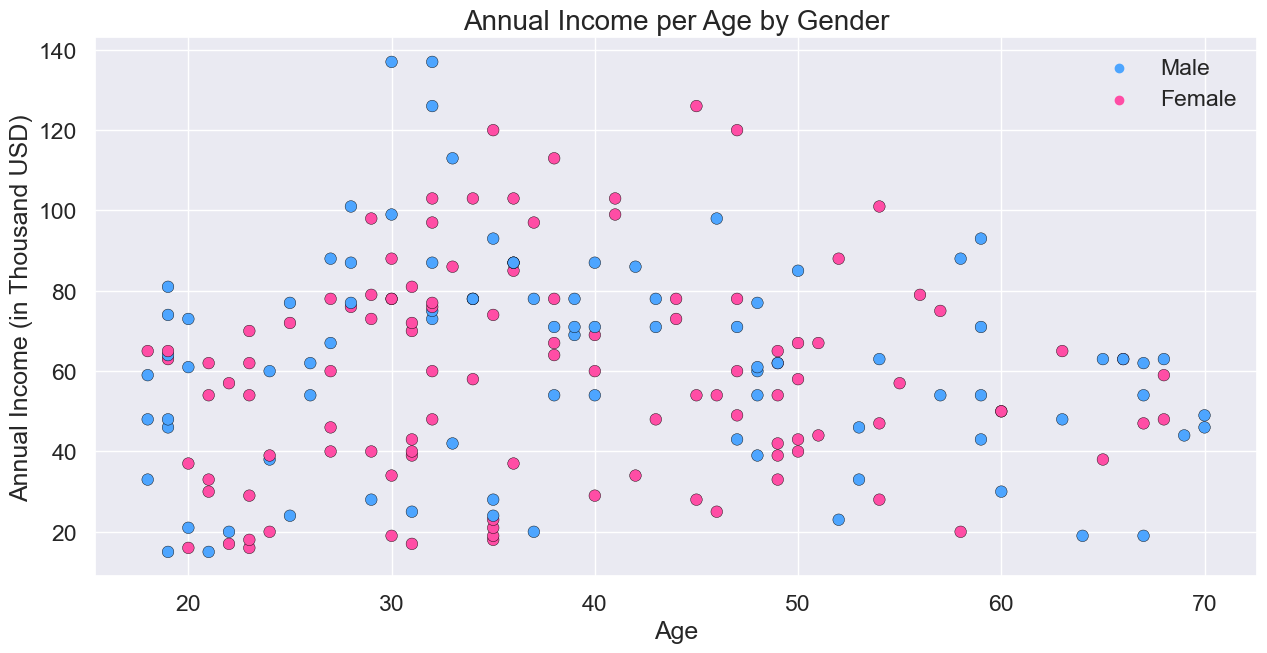

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
sns.set(font_scale=1.5)
ax = sns.scatterplot(y=data['Annual_Income'], x=data['Age'], hue=data['Gender'], palette=custom_palette, s=70,edgecolor='black', linewidth=0.3)
ax.set_ylabel('Annual Income (in Thousand USD)')
ax.legend(loc ='upper right')

plt.title('Annual Income per Age by Gender', fontsize = 20)
plt.show()

In [28]:
data['Spending_Score'].head()

0    39
1    81
2     6
3    77
4    40
Name: Spending_Score, dtype: int64

In [29]:
data['Spending_Score'].dtype

dtype('int64')

In [30]:
data['Spending_Score'].describe()

count    200.000000
mean      50.200000
std       25.823522
min        1.000000
25%       34.750000
50%       50.000000
75%       73.000000
max       99.000000
Name: Spending_Score, dtype: float64

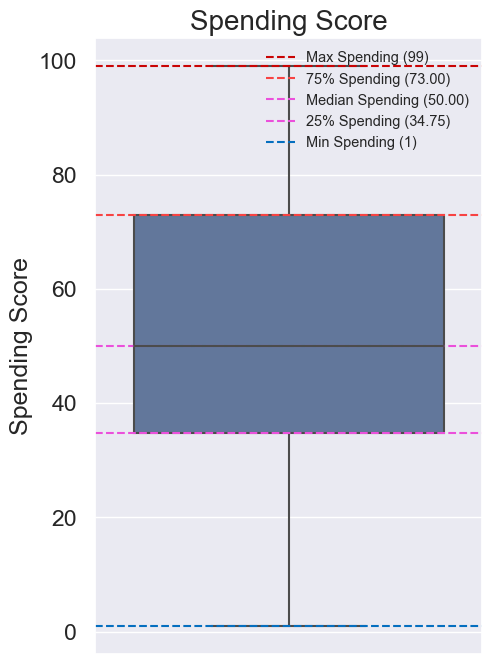

In [31]:
fig, ax = plt.subplots(figsize=(5,8))
sns.set(font_scale=1.5)
ax = sns.boxplot(y=data['Spending_Score'], color="#5975A4")
ax.axhline(y=data['Spending_Score'].max(), linestyle='--',color='#c90404', label=f'Max Spending ({data.Spending_Score.max()})')
ax.axhline(y=data['Spending_Score'].describe()[6], linestyle='--',color='#f74343', label=f'75% Spending ({data.Spending_Score.describe()[6]:.2f})')
ax.axhline(y=data['Spending_Score'].median(), linestyle='--',color='#eb50db', label=f'Median Spending ({data.Spending_Score.median():.2f})')
ax.axhline(y=data['Spending_Score'].describe()[4], linestyle='--',color='#eb50db', label=f'25% Spending ({data.Spending_Score.describe()[4]:.2f})')
ax.axhline(y=data['Spending_Score'].min(), linestyle='--',color='#046ebf', label=f'Min Spending ({data.Spending_Score.min()})')
ax.legend(fontsize='xx-small', loc='upper right')
ax.set_ylabel('Spending Score')

plt.title('Spending Score', fontsize = 20)
plt.show()

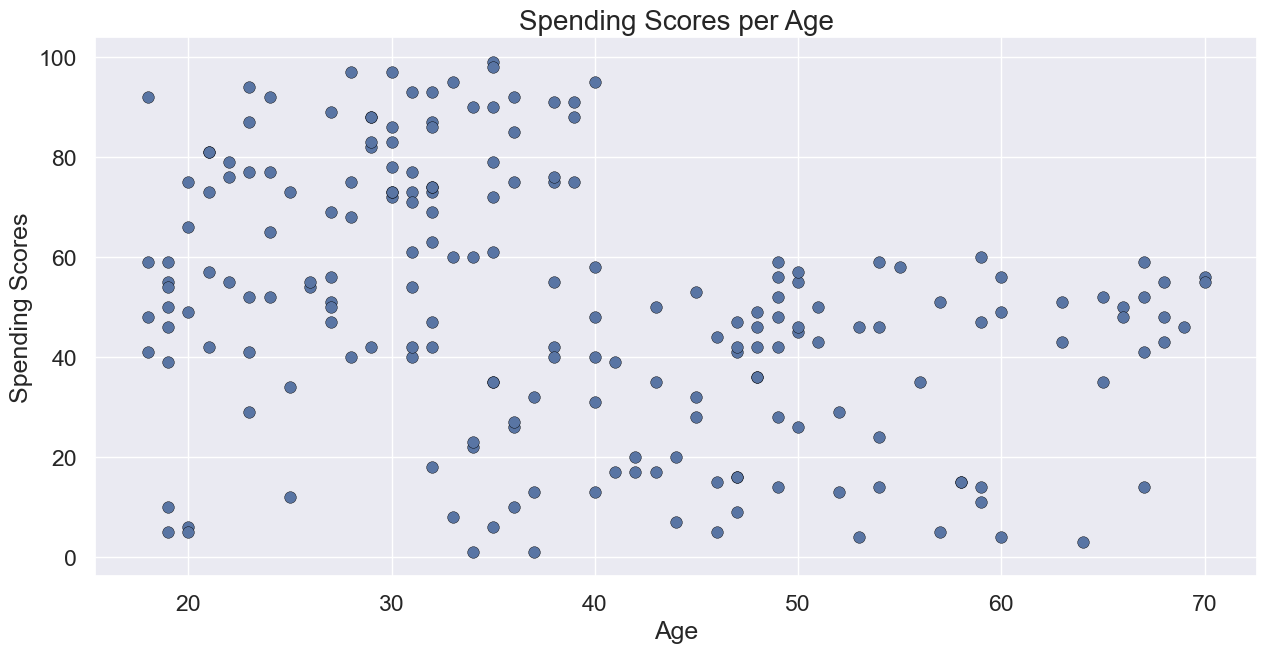

In [32]:
fig, ax = plt.subplots(figsize=(15,7))
sns.set(font_scale=1.5)
ax = sns.scatterplot(y=data['Spending_Score'], x=data['Age'], s=70, color='#5975A4', edgecolor='black', linewidth=0.3)
ax.set_ylabel('Spending Scores')

plt.title('Spending Scores per Age', fontsize = 20)
plt.show()

In [33]:
data[data['Gender']=='Male'].Annual_Income.describe()

count     88.000000
mean      62.227273
std       26.638373
min       15.000000
25%       45.500000
50%       62.500000
75%       78.000000
max      137.000000
Name: Annual_Income, dtype: float64

In [34]:
data[data['Gender']=='Female'].Annual_Income.describe()

count    112.000000
mean      59.250000
std       26.011952
min       16.000000
25%       39.750000
50%       60.000000
75%       77.250000
max      126.000000
Name: Annual_Income, dtype: float64

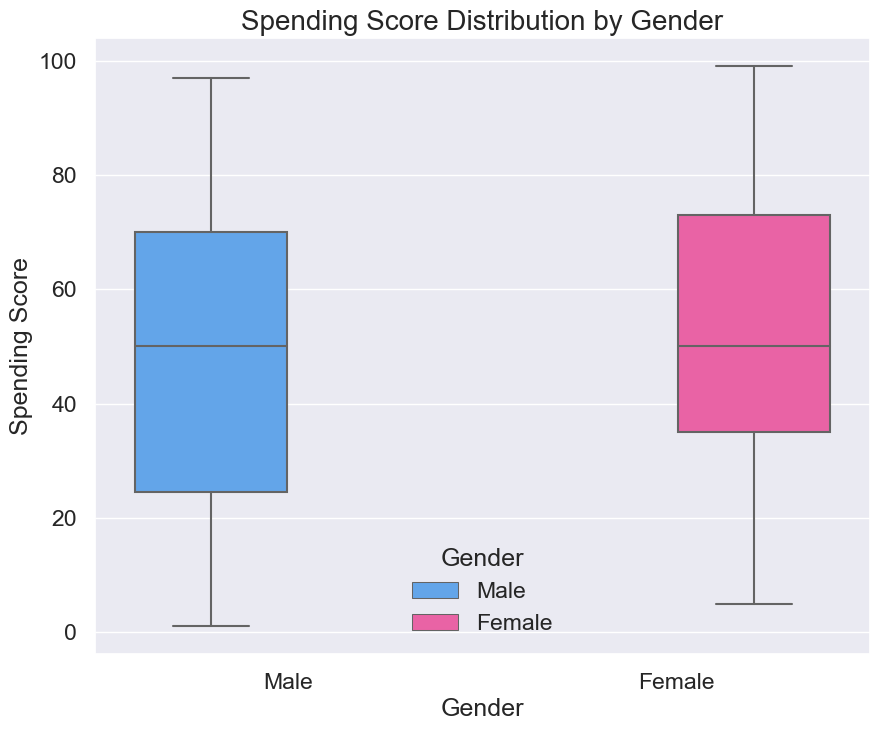

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.5)
ax = sns.boxplot(x=data['Gender'], y=data["Spending_Score"], hue=data['Gender'], palette=custom_palette)
ax.set_ylabel('Spending Score')

plt.title('Spending Score Distribution by Gender', fontsize = 20)
plt.show()

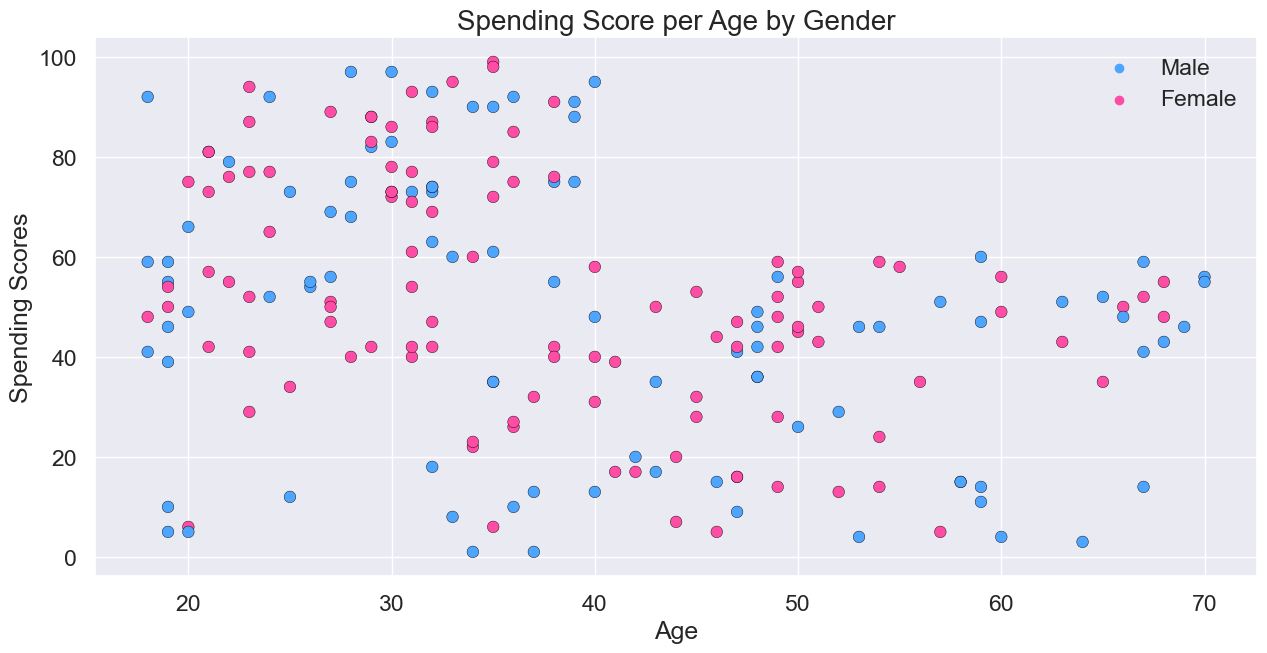

In [36]:
fig, ax = plt.subplots(figsize=(15,7))
sns.set(font_scale=1.5)
ax = sns.scatterplot(y=data['Spending_Score'], x=data['Age'], hue=data['Gender'], palette= custom_palette , s=70,edgecolor='black', linewidth=0.3)
ax.set_ylabel('Spending Scores')
ax.legend(loc ='upper right')

plt.title('Spending Score per Age by Gender', fontsize = 20)
plt.show()

In [37]:
# Select relevant features for clustering
features = ['Annual_Income', 'Spending_Score']
X = data[features]
X

,Annual_Income,Spending_Score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


In [38]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
X_scaled 

array([[-1.73899919, -0.43480148],
       [-1.73899919,  1.19570407],
       [-1.70082976, -1.71591298],
       [-1.70082976,  1.04041783],
       [-1.66266033, -0.39597992],
       [-1.66266033,  1.00159627],
       [-1.62449091, -1.71591298],
       [-1.62449091,  1.70038436],
       [-1.58632148, -1.83237767],
       [-1.58632148,  0.84631002],
       [-1.58632148, -1.4053405 ],
       [-1.58632148,  1.89449216],
       [-1.54815205, -1.36651894],
       [-1.54815205,  1.04041783],
       [-1.54815205, -1.44416206],
       [-1.54815205,  1.11806095],
       [-1.50998262, -0.59008772],
       [-1.50998262,  0.61338066],
       [-1.43364376, -0.82301709],
       [-1.43364376,  1.8556706 ],
       [-1.39547433, -0.59008772],
       [-1.39547433,  0.88513158],
       [-1.3573049 , -1.75473454],
       [-1.3573049 ,  0.88513158],
       [-1.24279661, -1.4053405 ],
       [-1.24279661,  1.23452563],
       [-1.24279661, -0.7065524 ],
       [-1.24279661,  0.41927286],
       [-1.20462718,

In [40]:
# Determine the optimal number of clusters using the elbow method
wcss = [] #is the sum of the squared differences between each point in a cluster and the centroid of that cluster. 
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

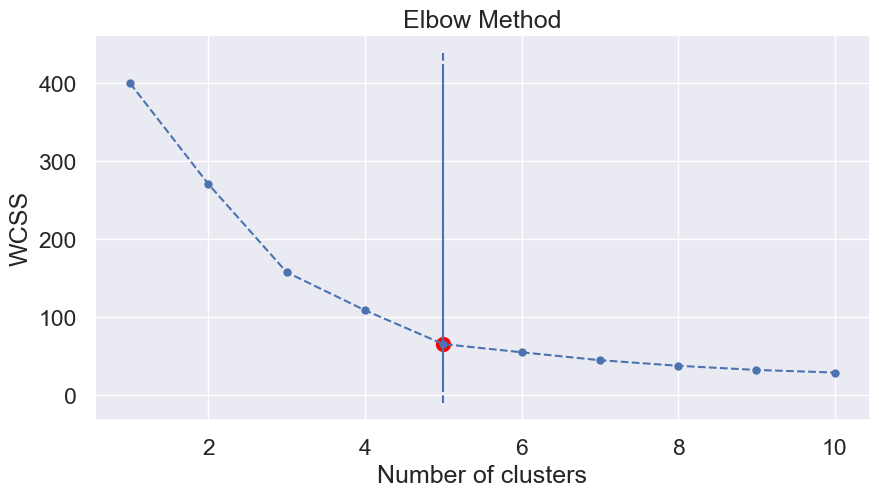

In [41]:
# Plot the elbow method result
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method') #method is used to determine the optimal number of clusters by plotting the WCSS for different numbers of clusters 
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# Find the knee location
knee = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing') #from here we knew that the best is 5 clustering
plt.vlines(knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.scatter(knee.knee, wcss[knee.knee - 1], color='red', s=100)

# plot the knee location
plt.vlines(knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.scatter(knee.knee, knee.knee_y, color='red', s=30)

plt.show()

In [42]:
# Apply K-means clustering with the optimal number of clusters
optimal_clusters = 5  # Determined from the elbow method graph
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

In [43]:
# Apply K-means clustering with the optimal number of clusters
optimal_clusters = knee.knee  # Determined from the elbow method graph
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

In [44]:
kmeans 

KMeans(n_clusters=5, n_init=10, random_state=42)

In [45]:
clusters

array([2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0,
       2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 4, 0, 4, 1, 4, 1, 4,
       0, 4, 1, 4, 1, 4, 1, 4, 1, 4, 0, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4])

In [46]:
# Add the cluster labels to the original dataset
data['Cluster'] = clusters

In [47]:
km = KMeans(n_clusters=5)
y_means = km.fit_predict(X)

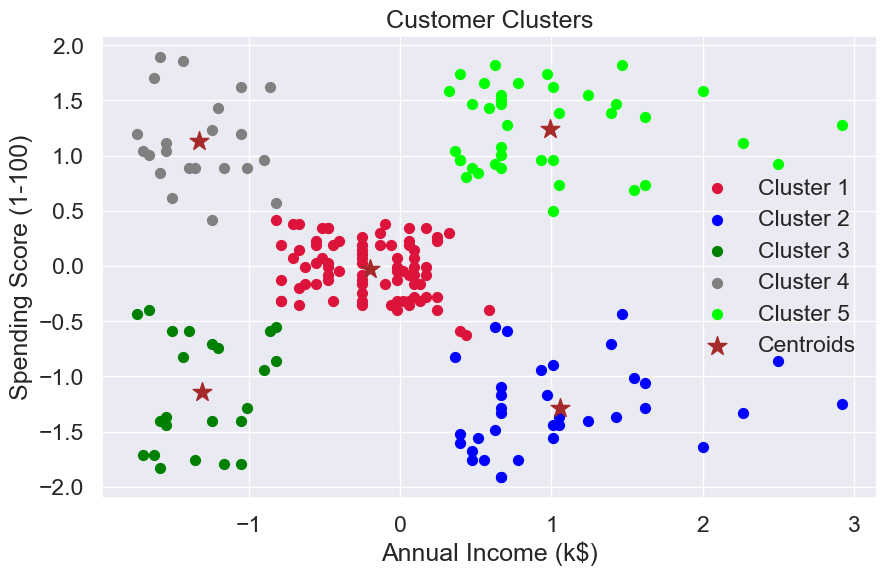

In [48]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[clusters == 0, 0], X_scaled[clusters == 0, 1], s=50, c='Crimson', label='Cluster 1')
plt.scatter(X_scaled[clusters == 1, 0], X_scaled[clusters == 1, 1], s=50, c='blue', label='Cluster 2')
plt.scatter(X_scaled[clusters == 2, 0], X_scaled[clusters == 2, 1], s=50, c='green', label='Cluster 3')
plt.scatter(X_scaled[clusters == 3, 0], X_scaled[clusters == 3, 1], s=50, c='Gray', label='Cluster 4')
plt.scatter(X_scaled[clusters == 4, 0], X_scaled[clusters == 4, 1], s=50, c='Lime', label='Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],  marker='*', s=200 , c='brown', label='Centroids')
plt.title('Customer Clusters')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [49]:
data["Target"]=y_means

In [50]:
Clustered_data=data
Clustered_data.head()

,Gender,Age,Annual_Income,Spending_Score,Cluster,Target
0,Male,19,15,39,2,1
1,Male,21,15,81,3,3
2,Female,20,16,6,2,1
3,Female,23,16,77,3,3
4,Female,31,17,40,2,1


In [51]:
X=Clustered_data.iloc[:,1:5]
y=Clustered_data.iloc[:,-1]

In [52]:
X.head()

,Age,Annual_Income,Spending_Score,Cluster
0,19,15,39,2
1,21,15,81,3
2,20,16,6,2
3,23,16,77,3
4,31,17,40,2


In [53]:
y.head()

0    1
1    3
2    1
3    3
4    1
Name: Target, dtype: int32

In [54]:
if 'Gender' in data.columns:
    le = LabelEncoder()
    data['Gender'] = le.fit_transform(data['Gender'])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [57]:
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

In [58]:
gbdt.fit(X_train,y_train)
y_pred=gbdt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.975

In [59]:
y_pred=gbdt.predict(X_test)
y_pred

array([4, 3, 1, 2, 2, 4, 4, 2, 2, 4, 4, 2, 0, 4, 2, 0, 4, 2, 4, 4, 2, 1,
       2, 4, 4, 4, 4, 4, 0, 4, 3, 1, 4, 4, 2, 4, 0, 0, 2, 4])

In [60]:
prediction = pd.DataFrame({'Original Value': y_test, 'Predicted Value': y_pred})

# Print the DataFrame
display(prediction)

,Original Value,Predicted Value
95,4,4
15,3,3
30,1,1
158,2,2
128,2,2
115,4,4
69,4,4
170,2,2
174,2,2
45,3,4


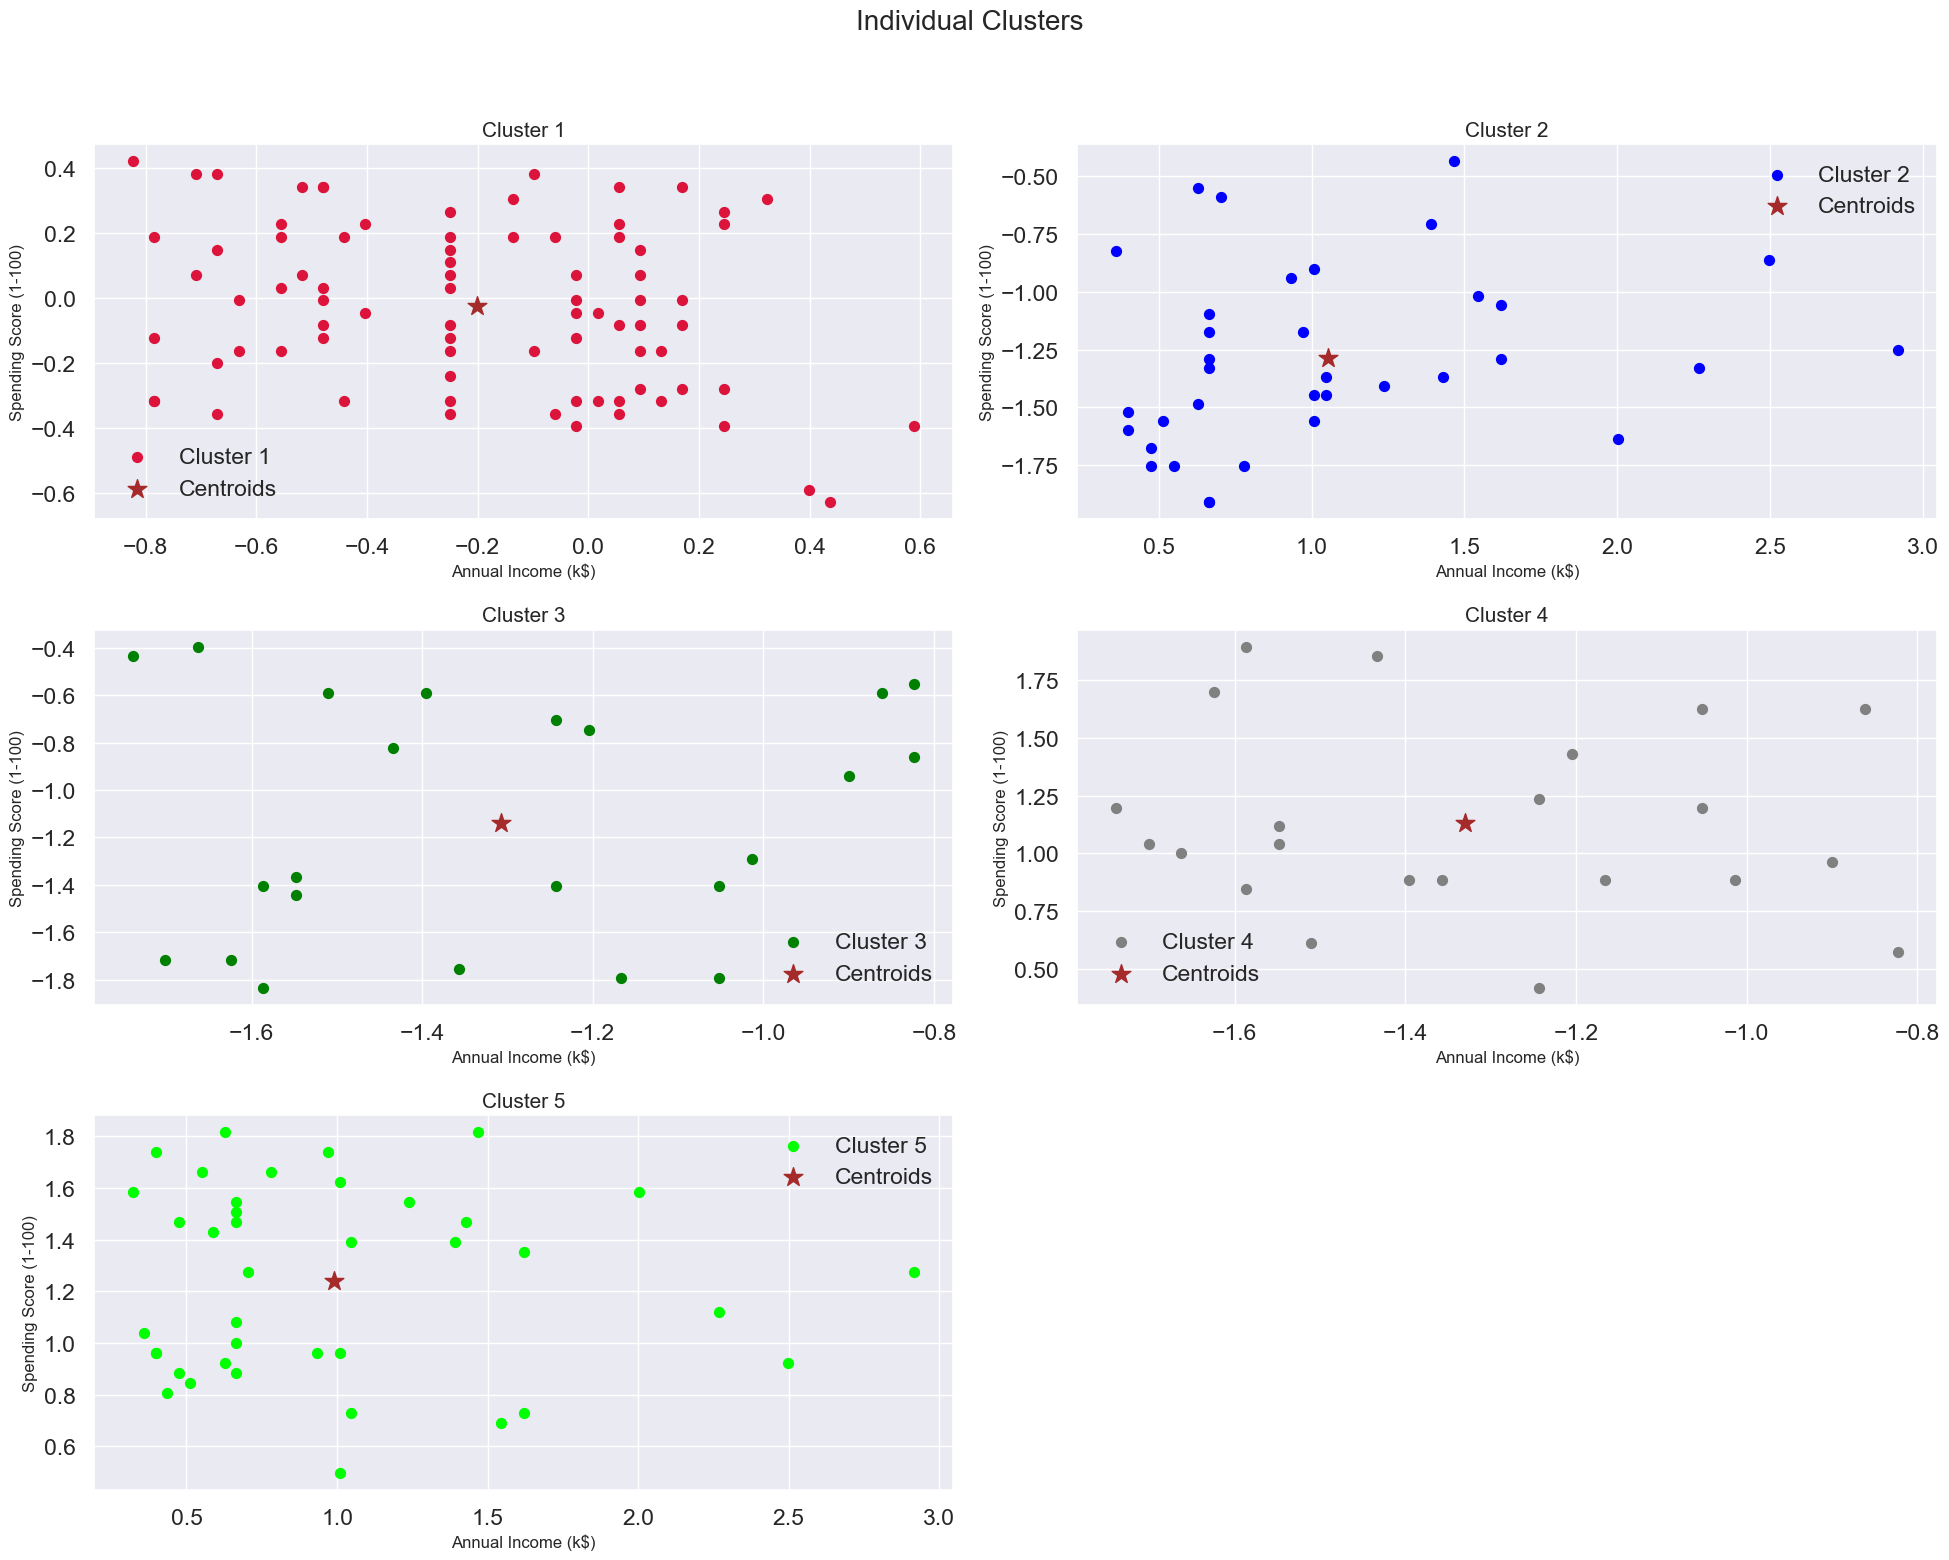

In [61]:
# Plot individual clusters
fig, axs = plt.subplots(3, 2, figsize=(20, 16))
axs = axs.flatten()
colors = ['Crimson', 'blue', 'green', 'Gray', 'Lime']
cluster_titles = [f'Cluster {i+1}' for i in range(optimal_clusters)]

for i in range(optimal_clusters):
    axs[i].scatter(X_scaled[clusters == i, 0], X_scaled[clusters == i, 1], s=50, c=colors[i], label=cluster_titles[i])
    axs[i].scatter(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], marker='*', s=200, c='brown', label='Centroids')
    axs[i].set_title(cluster_titles[i], fontsize=15)
    axs[i].set_xlabel('Annual Income (k$)', fontsize=12)
    axs[i].set_ylabel('Spending Score (1-100)', fontsize=12)
    axs[i].legend()

# Adjust layout
fig.delaxes(axs[5])  # remove extra subplot
plt.suptitle('Individual Clusters', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
